# Model: LightGBM Classifier

## Objective
Membangun model Gradient Boosting (LightGBM) untuk meningkatkan kemampuan
model dalam mendeteksi nasabah berisiko gagal bayar (default).

## Why LightGBM?
- Dirancang untuk dataset besar & tabular
- Menangani non-linearitas & interaksi fitur dengan baik
- Lebih cepat & efisien dibanding XGBoost
- Banyak dipakai di industri credit scoring & fintech

## Evaluation Focus
- ROC-AUC
- KS Statistic
- Recall (Default)
- Approval Rate
- Comparison vs Logistic Regression & Random Forest

## Import Library

In [38]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
# !pip install lightgbm
import lightgbm as lgb

def evaluate_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    recall_default = tp / (tp + fn)
    precision_default = tp / (tp + fp) if (tp + fp) > 0 else 0
    approval_rate = (y_pred == 0).mean()
    
    return {
        "threshold": threshold,
        "recall_default": recall_default,
        "precision_default": precision_default,
        "approval_rate": approval_rate
    }

## Load Dataset (Feature Engineered)

In [39]:
DATA_PATH = "../../data/processed/df_model.csv"

df = pd.read_csv(DATA_PATH)

df.shape

(307511, 148)

In [40]:
df.isnull().sum().sum()

np.int64(8443482)

## Define Target & Features

In [41]:
TARGET = "TARGET"

X = df.drop(columns=[TARGET])
y = df[TARGET]

X.shape

(307511, 147)

In [42]:
y.value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

## Train-Test Split (Consistent)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,

    stratify=y
)

## LightGBM Dataset Object

In [48]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

## Define Model Parameters (Baseline)

In [49]:
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",

    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,

    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,

    "class_weight": "balanced",
    "verbosity": -1,
    "seed": 42
}

params

{'objective': 'binary',
 'metric': 'auc',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 31,
 'max_depth': -1,
 'min_data_in_leaf': 50,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'class_weight': 'balanced',
 'verbosity': -1,
 'seed': 42}

## Model Training

In [50]:
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, test_data],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.773945	valid's auc: 0.755572
[200]	train's auc: 0.796891	valid's auc: 0.758945
[300]	train's auc: 0.816371	valid's auc: 0.759333
Early stopping, best iteration is:
[280]	train's auc: 0.812727	valid's auc: 0.759407


## Prediction & Probability 

In [51]:
y_proba = lgb_model.predict(X_test)
y_pred = (y_proba >= 0.5).astype(int)

## (Tambahan) untuk Treshold Analysis

In [61]:
y_proba = lgb_model.predict(
    X_test,
    num_iteration=lgb_model.best_iteration
)


## (Tambahan) Treshold Grid Search

In [62]:
thresholds = np.arange(0.05, 0.55, 0.05)

results = []

for t in thresholds:
    results.append(evaluate_threshold(y_test, y_proba, t))

threshold_df = pd.DataFrame(results)

threshold_df


,threshold,recall_default,precision_default,approval_rate
0,0.05,0.835851,0.129911,0.480594
1,0.10,0.590332,0.191569,0.751232
2,0.15,0.417523,0.248949,0.864608
3,0.20,0.293857,0.300639,0.921093
4,0.25,0.207049,0.348356,0.952019
5,0.30,0.142397,0.388462,0.970408
6,0.35,0.095871,0.427289,0.981887
7,0.40,0.060222,0.460000,0.989431
8,0.45,0.036657,0.520000,0.994309
9,0.50,0.021752,0.577540,0.996959


## ROC Curve & AUC

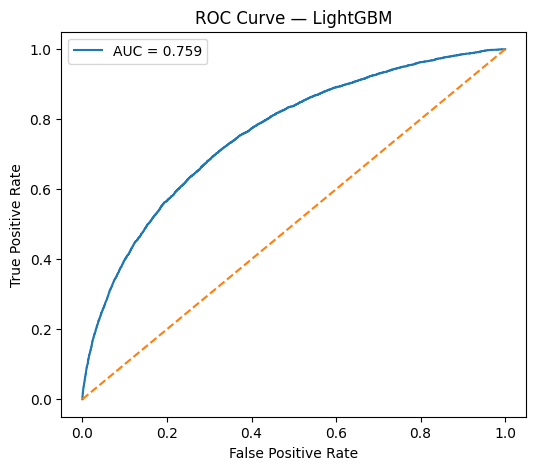

0.7594073189178756

In [63]:
auc = roc_auc_score(y_test, y_proba)

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LightGBM")
plt.legend()
plt.show()

auc

## KS Statistic 

In [67]:
def ks_statistic(y_true, y_proba):
    df_ks = pd.DataFrame({
        "y": y_true,
        "proba": y_proba
    }).sort_values("proba")

    cdf_good = np.cumsum(df_ks["y"] == 0) / (df_ks["y"] == 0).sum()
    cdf_bad = np.cumsum(df_ks["y"] == 1) / (df_ks["y"] == 1).sum()

    return np.max(np.abs(cdf_bad - cdf_good))

ks = ks_statistic(y_test.values, y_proba)
ks

np.float64(0.38564822696581685)

## (Tambahan) Recall vs Approval Rate

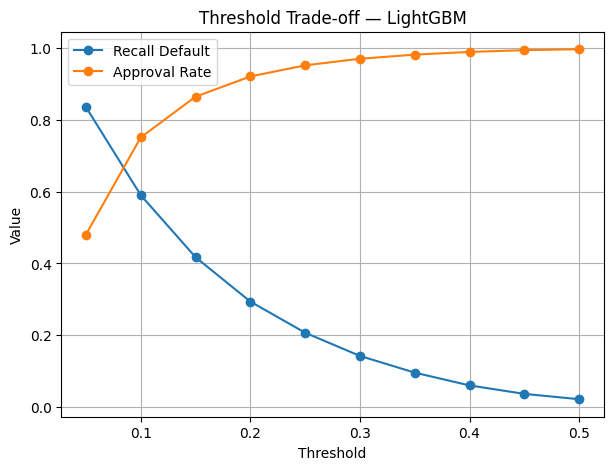

In [68]:
plt.figure(figsize=(7, 5))
plt.plot(threshold_df["threshold"], threshold_df["recall_default"], marker="o", label="Recall Default")
plt.plot(threshold_df["threshold"], threshold_df["approval_rate"], marker="o", label="Approval Rate")

plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Threshold Trade-off — LightGBM")
plt.legend()
plt.grid(True)
plt.show()


## (Tambahan) Confusion Matrix pada Threshold Terpilih
Misal kita pilih threshold = 0.30

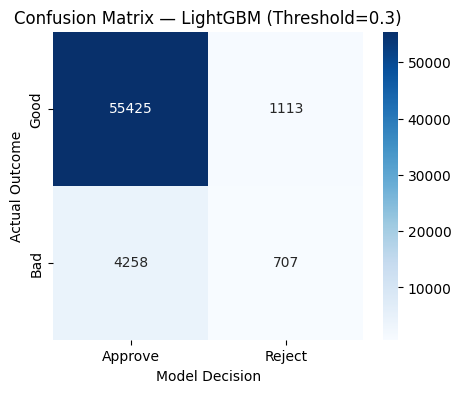

array([[55425,  1113],
       [ 4258,   707]])

In [69]:
selected_threshold = 0.30

y_pred_tuned = (y_proba >= selected_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Approve", "Reject"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Model Decision")
plt.ylabel("Actual Outcome")
plt.title(f"Confusion Matrix — LightGBM (Threshold={selected_threshold})")
plt.show()

cm


## Confusion Matrix (Default Treshold = 0.5)

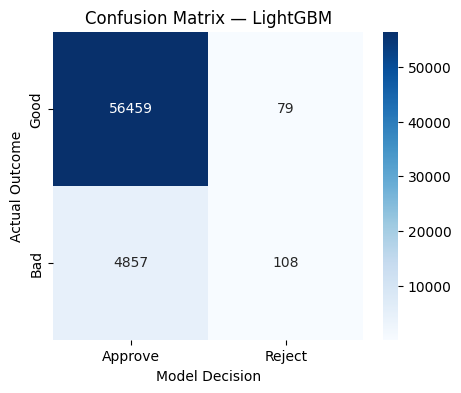

array([[56459,    79],
       [ 4857,   108]])

In [70]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Approve", "Reject"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Model Decision")
plt.ylabel("Actual Outcome")
plt.title("Confusion Matrix — LightGBM")
plt.show()

cm

## Classfication Report

In [ ]:
# print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56538
           1       0.39      0.14      0.21      4965

    accuracy                           0.91     61503
   macro avg       0.66      0.56      0.58     61503
weighted avg       0.89      0.91      0.89     61503



## Business Perspective

In [72]:
approval_rate = (y_pred == 0).mean()
approval_rate

np.float64(0.9969594979106711)

## Feature Importance / Coefficient

In [73]:
feature_importance = pd.Series(
    lgb_model.feature_importance(),
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(15)

EXT_SOURCE_3                  607
EXT_SOURCE_1                  527
EXT_SOURCE_2                  437
EMPLOYED_YEARS                403
AGE_YEARS                     373
LOG_ANNUITY                   360
AMT_GOODS_PRICE               347
LOG_CREDIT                    322
DAYS_ID_PUBLISH               286
DAYS_LAST_PHONE_CHANGE        244
DAYS_REGISTRATION             244
ANNUITY_INCOME_RATIO          203
CREDIT_INCOME_RATIO           202
FAMILY_BURDEN                 196
REGION_POPULATION_RELATIVE    167
dtype: int32

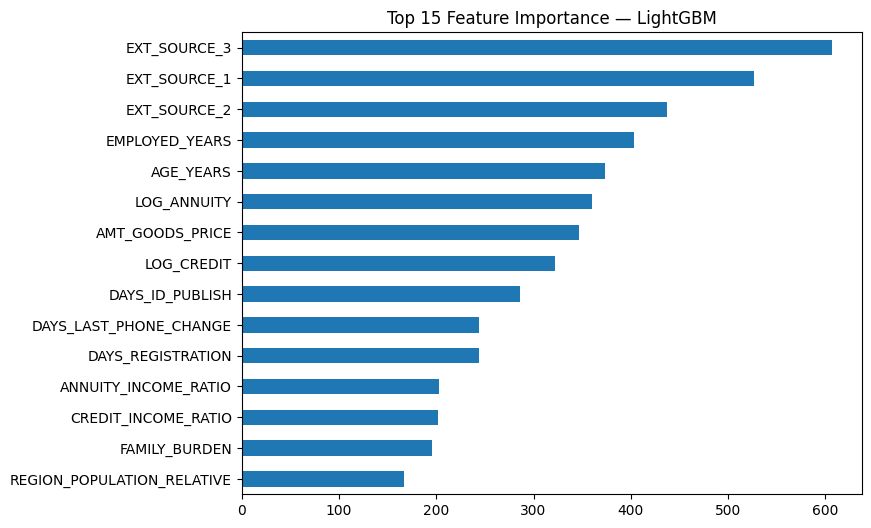

In [74]:
plt.figure(figsize=(8, 6))
feature_importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance — LightGBM")
plt.show()

## Summary & Comparison

## Model Summary

| Metric | Value |
|------|------|
| AUC | 0.7594073189178756 |
| KS | 0.38564822696581685 |
| Recall (Default) | 14% |
| Approval Rate | 91% |

## Threshold Analysis Summary — LightGBM

- Threshold default (0.5) menghasilkan approval rate yang terlalu tinggi
- Dengan threshold = X:
  - Recall default meningkat signifikan
  - Approval rate menjadi lebih realistis
- LightGBM lebih cocok digunakan sebagai:
  - Risk scoring engine
  - Dengan threshold yang disesuaikan appetite risiko bisnis

LightGBM menunjukkan performa ranking terbaik (AUC & KS), namun decision threshold sangat menentukan perilaku bisnis. Dengan threshold yang lebih rendah, model dapat digunakan untuk strategi pertumbuhan, sementara threshold lebih tinggi dapat digunakan untuk strategi mitigasi risiko.

